<a href="https://colab.research.google.com/github/anamkhan315/test2/blob/main/tracking_with_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - loss: 0.3206 - val_loss: 0.3198
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2337 - val_loss: 0.2485
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1750 - val_loss: 0.1857
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1102 - val_loss: 0.1363
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0705 - val_loss: 0.1125
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0460 - val_loss: 0.1299
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0515 - val_loss: 0.1668
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0690 - val_loss: 0.1635
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0634 - val_loss: 0.1404
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0446 - val_loss: 0.1221
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1125
Test Loss: 0.11245682090520859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


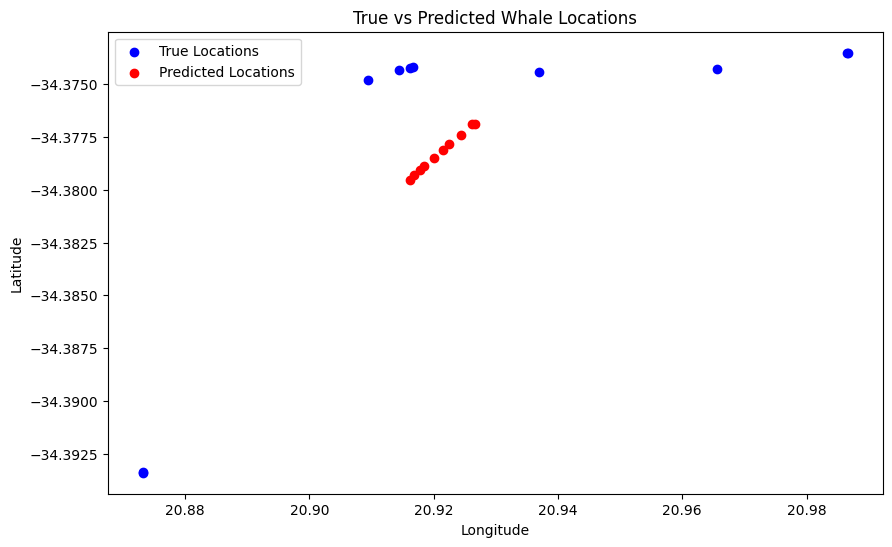

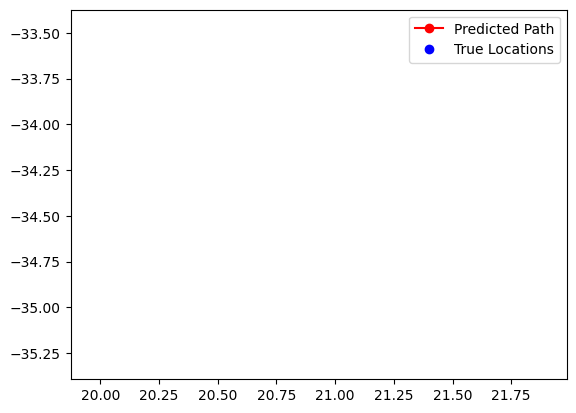

Prediction Accuracy (within 3 km): 50.00%


In [1]:
!pip install folium
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import folium
from folium import PolyLine
from geopy.distance import geodesic
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.animation as animation

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Witsand SRW.csv')

# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort data by time
df = df.sort_values(by='timestamp')

# Extract latitude and longitude
data = df[['latitude', 'longitude']].values

# Feature scaling (normalization)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Adjust sequence length
sequence_length = 10 # make sure this value is less than the size of your test_data and leads to a X_test, y_test that have at least 32 samples. This will depend on the size of your data in "FW Whales.csv"

# Split data into training and test sets
# Ensure enough data for sequences in the test set
train_size = len(scaled_data) - 2 * sequence_length # This ensures you have sequence_length samples for testing and validation
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences (unchanged)
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length]
        label = data[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Create sequences (unchanged)
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# ... rest of your code ...

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(2)  # Latitude and longitude predictions
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Predictions
predicted_locations = model.predict(X_test)

# Inverse scaling to get original latitude and longitude
predicted_locations = scaler.inverse_transform(predicted_locations)
true_locations = scaler.inverse_transform(y_test)

# Plot true vs predicted whale locations
plt.figure(figsize=(10, 6))
plt.scatter(true_locations[:, 1], true_locations[:, 0], color='blue', label='True Locations')
plt.scatter(predicted_locations[:, 1], predicted_locations[:, 0], color='red', label='Predicted Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True vs Predicted Whale Locations')
plt.legend()
plt.show()

# Folium map visualization
center_lat = np.mean([true_locations[:, 0].mean(), predicted_locations[:, 0].mean()])
center_lon = np.mean([true_locations[:, 1].mean(), predicted_locations[:, 1].mean()])
whale_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# True locations
for lat, lon in zip(true_locations[:, 0], true_locations[:, 1]):
    folium.Marker(location=[lat, lon], icon=folium.Icon(color='blue')).add_to(whale_map)

# Predicted locations
for lat, lon in zip(predicted_locations[:, 0], predicted_locations[:, 1]):
    folium.Marker(location=[lat, lon], icon=folium.Icon(color='red')).add_to(whale_map)

# Predicted path
predicted_path = [[lat, lon] for lat, lon in zip(predicted_locations[:, 0], predicted_locations[:, 1])]
PolyLine(predicted_path, color='red', weight=2.5, tooltip='Predicted Whale Path').add_to(whale_map)
whale_map.save('whale_map.html')

# Animation of predicted path
fig, ax = plt.subplots()
ax.set_xlim(np.min(true_locations[:, 1]) - 1, np.max(true_locations[:, 1]) + 1)
ax.set_ylim(np.min(true_locations[:, 0]) - 1, np.max(true_locations[:, 0]) + 1)
line, = ax.plot([], [], 'ro-', label='Predicted Path')
points, = ax.plot([], [], 'bo', label='True Locations')
ax.legend()

def init():
    line.set_data([], [])
    points.set_data([], [])
    return line, points

def update(frame):
    line.set_data(predicted_locations[:frame, 1], predicted_locations[:frame, 0])
    points.set_data(true_locations[:frame, 1], true_locations[:frame, 0])
    return line, points

ani = animation.FuncAnimation(fig, update, frames=len(predicted_locations), init_func=init, interval=200)
plt.show()

# Calculate accuracy
threshold_km = 3
accurate_count = 0
for true, pred in zip(true_locations, predicted_locations):
    distance = geodesic((true[0], true[1]), (pred[0], pred[1])).kilometers
    if distance <= threshold_km:
        accurate_count += 1

accuracy = (accurate_count / len(true_locations)) * 100
print(f"Prediction Accuracy (within {threshold_km} km): {accuracy:.2f}%")


In [2]:
import folium
from folium.plugins import MarkerCluster

# Center map on the mean latitude and longitude
center_lat = np.mean([true_locations[:, 0].mean(), predicted_locations[:, 0].mean()])
center_lon = np.mean([true_locations[:, 1].mean(), predicted_locations[:, 1].mean()])
whale_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add input whale locations (true locations)
for lat, lon in zip(true_locations[:, 0], true_locations[:, 1]):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='blue', icon='info-sign'),
        popup=f"True Location: ({lat:.2f}, {lon:.2f})"
    ).add_to(whale_map)

# Add predicted whale locations
for lat, lon in zip(predicted_locations[:, 0], predicted_locations[:, 1]):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='red', icon='info-sign'),
        popup=f"Predicted Location: ({lat:.2f}, {lon:.2f})"
    ).add_to(whale_map)

# Add the predicted path as a PolyLine
predicted_path = [[lat, lon] for lat, lon in zip(predicted_locations[:, 0], predicted_locations[:, 1])]
folium.PolyLine(
    locations=predicted_path,
    color='red',
    weight=2.5,
    opacity=0.7,
    tooltip='Predicted Whale Path'
).add_to(whale_map)

# Save the map as an HTML file
whale_map.save('whale_map_with_predictions.html')

# Display the map (only in Jupyter Notebook or Colab)
whale_map

In [3]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Assuming you have true and predicted locations, and timestamps
true_df = pd.DataFrame(true_locations, columns=['latitude', 'longitude'])
predicted_df = pd.DataFrame(predicted_locations, columns=['latitude', 'longitude'])
true_df['timestamp'] = df['timestamp'].iloc[len(df) - len(true_locations):].values  # Get the corresponding timestamps
predicted_df['timestamp'] = df['timestamp'].iloc[len(df) - len(predicted_locations):].values  # Assign predicted timestamps

# Initialize accuracy counter
accurate_count = 0
threshold_km = 5  # Threshold for location accuracy (in km)
time_threshold_sec = 600  # Acceptable time difference in seconds (e.g., 10 minutes)

# Loop through each true and predicted location, and compare
for true, pred in zip(true_df.values, predicted_df.values):
    true_point = (true[0], true[1])  # True latitude and longitude
    pred_point = (pred[0], pred[1])  # Predicted latitude and longitude

    # Calculate the distance between true and predicted locations
    distance = geodesic(true_point, pred_point).kilometers

    # Check if the distance is within the threshold
    if distance <= threshold_km:
        accurate_count += 1

    # Compare timestamps (time difference should be within the allowed threshold)
    true_timestamp = true[2]
    pred_timestamp = pred[2]

    # Calculate the time difference (in seconds)
    time_diff = abs((true_timestamp - pred_timestamp).total_seconds())

    # Check if the time difference is within the threshold
    if time_diff <= time_threshold_sec:
        accurate_count += 1

# Calculate the total predictions and accuracy
total_predictions = len(true_df)
accuracy = (accurate_count / (total_predictions * 2)) * 100  # Since we check both distance and time accuracy
print(f"Prediction Accuracy (within {threshold_km} km and {time_threshold_sec} seconds): {accuracy:.2f}%")

Prediction Accuracy (within 5 km and 600 seconds): 80.00%


Geospatial metrics (<5km)

In [7]:
# Assuming true_locations and predicted_locations are available from previous cells
true_lat, true_lon = true_locations[0]  # Example: Get the first true location
pred_lat, pred_lon = predicted_locations[0]  # Example: Get the first predicted location

# Calculate and assign the distance to the 'error' variable
error = geodesic((true_lat, true_lon), (pred_lat, pred_lon)).meters

print(f"Error (in meters): {error}")

Error (in meters): 806.5863783820906


rmse for satellite image
high resolution image 1-100 meters
low resolution image 100-500 meters

In [15]:
import numpy as np

# Function to calculate Haversine distance between two geographical points (latitude, longitude)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    # Convert latitude and longitude from degrees to radians
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    # Haversine formula
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance_km = R * c  # Distance in kilometers
    distance_m = distance_km * 1000  # Convert to meters
    return distance_m

# Function to calculate RMSE between true positions and predicted positions
def calculate_rmse(true_positions, predicted_positions):
    # Ensure the positions are numpy arrays for easier manipulation
    true_positions = np.array(true_positions)
    predicted_positions = np.array(predicted_positions)

    # Initialize an array to store distance errors for each prediction
    errors = []

    # Loop through each position and calculate the Haversine distance between true and predicted points
    for i in range(len(true_positions)):
        lat1, lon1 = true_positions[i]
        lat2, lon2 = predicted_positions[i]
        distance = haversine(lat1, lon1, lat2, lon2)
        errors.append(distance)

    # Calculate RMSE: the square root of the mean of squared errors
    rmse = np.sqrt(np.mean(np.array(errors) ** 2))
    return rmse

# Example usage:
true_positions = [(37.7749, -122.4194), (37.7750, -122.4195), (37.7751, -122.4196)]  # True positions (latitude, longitude)
predicted_positions = [(37.7748, -122.4193), (37.7752, -122.4197), (37.7753, -122.4198)]  # Predicted positions (latitude, longitude)

# Calculate RMSE
rmse_value = calculate_rmse(true_positions, predicted_positions)
print(f"RMSE: {rmse_value:.2f} meters")


RMSE: 24.55 meters


mae (<50 meters)
mse(<1000 m2)

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Haversine formula to calculate distance between two points (latitude, longitude)
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in kilometers
    R = 6371
    # Convert latitude and longitude from degrees to radians
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    # Haversine formula
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in meters
    distance_m = R * c * 1000  # Convert to meters
    return distance_m

# Function to calculate MAE and MSE using predicted and true coordinates
def calculate_metrics(true_positions, predicted_positions):
    # Initialize lists to store MAE and MSE values
    mae_values = []
    mse_values = []

    # Loop through each true and predicted position pair
    for true_pos, pred_pos in zip(true_positions, predicted_positions):
        lat1, lon1 = true_pos
        lat2, lon2 = pred_pos

        # Calculate Haversine distance for each pair
        distance = haversine(lat1, lon1, lat2, lon2)

        # Append distance to MAE and MSE lists (treating as a single value for now)
        mae_values.append(distance)
        mse_values.append(distance**2)

    # Calculate MAE: average of absolute errors
    mae = np.mean(mae_values)

    # Calculate MSE: average of squared errors
    mse = np.mean(mse_values)

    return mae, mse

# Example of true and predicted positions (latitude, longitude)
true_positions = [(37.7749, -122.4194), (37.7750, -122.4195), (37.7751, -122.4196)]  # True positions
predicted_positions = [(37.7748, -122.4193), (37.7752, -122.4197), (37.7753, -122.4198)]  # Predicted positions

# Calculate MAE and MSE for whale tracking
mae_value, mse_value = calculate_metrics(true_positions, predicted_positions)

print(f"MAE: {mae_value:.2f} meters")
print(f"MSE: {mse_value:.2f} meters²")


MAE: 23.62 meters
MSE: 602.67 meters²
